# Business Understanding

## Wie (de opdrachtgever)? 

Appbakkers (Corné & Guido) is een bedrijf die (mobiele) applicaties ontwikkeld.  

## Wat (de opdracht)? 

Bij opname van een patiënt wordt er een elektrocardiogram (ECG) gemaakt. Hierbij worden alle elektrische impulsen in het hart geregistreerd, waardoor kan worden afgeleid welke gebieden van het hart naar behoren functioneren.  

Als een ECG is gemaakt, wordt het nu door een deskundige bekeken en gelabeld. Zo kan worden gezien of de patient een cardiovasculaire ziekte heeft. Nu kost dit labelen veel tijd en zijn er niet veel deskundigen die het accuraat kunnen labelen/onderzoeken. Om het labelen ervan makkelijker te maken is er een behoefte naar een model die de categorie kan bepalen aan de hand van een ECG.

<a id='categorieën'>De categorieën waarin deze ECG's zich kunnen bevinden:</a>

N - 0
* Normal
* Left/Right bundle branch block
* Atrial escape
* Nodal escape</br>

S - 1
* Atrial premature
* Aberrant atrial premature
* Nodal premature
* Supra-ventricular premature</br>

V - 2
* Premature ventricular contraction
* Ventricular escape</br>

F - 3
* Fusion of ventricular and normal</br>

Q - 4
* Paced
* Fusion of paced and normal
* Unclassifiable


## Wanneer (tijdsframe)? 

Deze opdracht voeren we uit vanaf 13 april ’22. Op deze dag hebben we de kennismaking gehad met onze opdrachtgever. Hierin hebben we de opdracht besproken en een aantal afspraken gemaakt. De einddatum van de opdracht zal zijn op 3 juni ’22. 

## Waarom (doel)? 

Het doel is om te achterhalen of hartslag een goede voorspeller kan zijn van de calciumscore. 

Als het model gemaakt is om dit te voorspellen kan deze verbeterd/uitgebreid worden met de resultaten en de calciumscore uitkomsten of de aanwezigheid van bradycardie/tachycardie/normale hartslag (en meer specifiek het aantal hartslagen per minuut) de calciumscore kan voorspellen.  

## Wat (wat gaan we gebruiken)? 

Door middel van Jupyter notebooks gaan wij het model ontwikkelen.  

# Data Understanding

Frequentie van de ECG's: 125Hz </br>
Data bron: Physionet's MIT-BIH Arrhythmia Dataset

### "mitbih_train.csv" en "mitbih_test.csv"

* Kolom 0 t/m 186          
    Een reeks aan voltages binnen een bereik van 0 tot 1, die één hartslag omvatten, **float** <br/>
* Kolom 187         
    [De categorie waarin deze bevind](#categorieën) , **integer**<br/>

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas_profiling as pp

%matplotlib inline

In [59]:
ecg1_train = pd.read_csv('Data/ECG/mitbih_train.csv',delimiter=',', header=None)
ecg1_test = pd.read_csv('Data/ECG/mitbih_test.csv',delimiter=',', header=None)

In [75]:
def plot_histogram(category,start,end):
    bins = end-start
    
    img=ecg1_train[ecg1_train[187]==category].values
    img=img[:,start:end]
    y=img.flatten()
    
    x=np.arange(start,end)
    for i in range(img.shape[0]-1):
        row=np.arange(start,end)
        x=np.concatenate((x, row), axis=None)
    plt.hist2d(x, y, bins=(bins,bins), cmap=plt.cm.jet)
    plt.show()

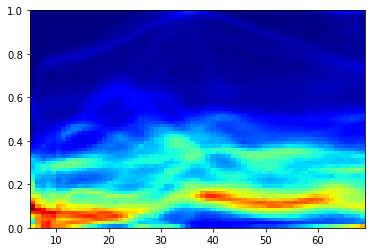

In [77]:
plot_histogram(0,5,70)

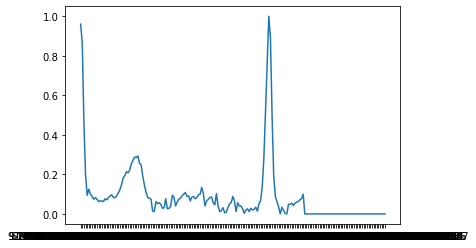

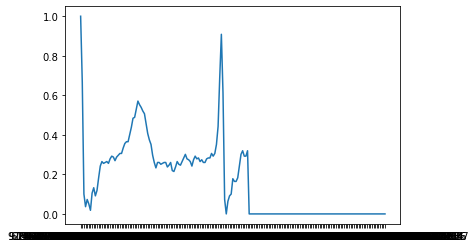

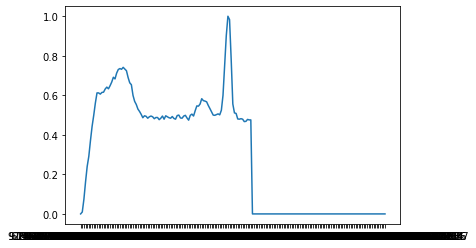

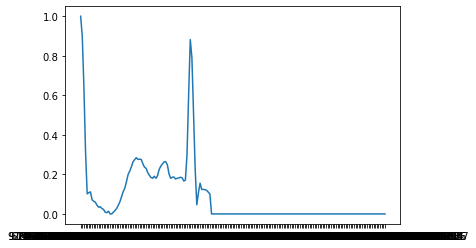

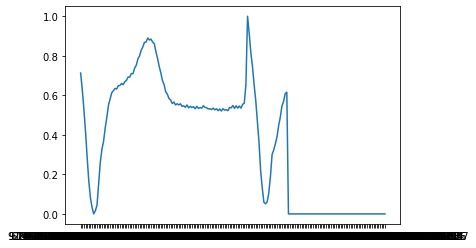

In [58]:
for i in range(0,4):
    plt.plot(ecg1_train[ecg1_train['0.000000000000000000e+00.88'] == i].iloc[2][:188])
    plt.show()

In [46]:
ecg1_train[ecg1_train['0.000000000000000000e+00.88'] == 4]

,9.779411554336547852e-01,9.264705777168273926e-01,6.813725233078002930e-01,2.450980395078659058e-01,1.544117629528045654e-01,1.911764740943908691e-01,1.519607901573181152e-01,8.578431606292724609e-02,5.882352963089942932e-02,4.901960864663124084e-02,...,0.000000000000000000e+00.79,0.000000000000000000e+00.80,0.000000000000000000e+00.81,0.000000000000000000e+00.82,0.000000000000000000e+00.83,0.000000000000000000e+00.84,0.000000000000000000e+00.85,0.000000000000000000e+00.86,0.000000000000000000e+00.87,0.000000000000000000e+00.88
81122,0.712610,0.629032,0.527859,0.414956,0.284457,0.164223,0.080645,0.032258,0.000000,0.016129,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
81123,1.000000,0.484848,0.541667,0.526515,0.522727,0.507576,0.496212,0.412879,0.284091,0.140152,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
81124,0.584046,0.500000,0.424501,0.324786,0.233618,0.128205,0.049858,0.000000,0.000000,0.028490,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
81125,1.000000,0.936170,0.878598,0.813517,0.727159,0.607009,0.496871,0.365457,0.272841,0.232791,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
81126,0.680412,0.584192,0.491409,0.379725,0.269759,0.149485,0.072165,0.012027,0.000000,0.012027,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87548,0.807018,0.494737,0.536842,0.529825,0.491228,0.484211,0.456140,0.396491,0.284211,0.136842,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
87549,0.718333,0.605000,0.486667,0.361667,0.231667,0.120000,0.051667,0.001667,0.000000,0.013333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
87550,0.906122,0.624490,0.595918,0.575510,0.530612,0.481633,0.444898,0.387755,0.322449,0.191837,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
87551,0.858228,0.645570,0.845570,0.248101,0.167089,0.131646,0.121519,0.121519,0.118987,0.103797,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
